In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from skimage.transform import radon, rescale
from scipy.interpolate import interp1d
import time

In [5]:
save_here = "C:/Users/tomerf/Desktop/reconstruction_examples_for_master/figures/"
%matplotlib notebook

In [6]:
# Object creation

# Create blank image
img_size = 512
phantom = np.zeros((img_size, img_size), dtype=np.uint8)

# Circle parameters
circle_center = (img_size // 2, img_size // 2)
circle_radius = 100
cv2.circle(phantom, circle_center, circle_radius, color=255, thickness=-1)

# Rectangle parameters (placed to the right of the circle)
rect_top_left = (img_size // 2 + 120, img_size // 2 - 160)
rect_bottom_right = (rect_top_left[0] + 60, rect_top_left[1] + 120)
cv2.rectangle(phantom, rect_top_left, rect_bottom_right, color=255, thickness=-1)

# Normalize to float [0,1] for Matplotlib
phantom_norm = phantom.astype(np.float32) / 255.0

In [7]:
%matplotlib notebook
# Save as vector images
plt.figure(figsize=(5, 5))
plt.imshow(phantom_norm, cmap='gray', interpolation='none')
# plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig(save_here + "phantom_circle_rectangle.svg", format='svg', bbox_inches='tight', pad_inches=0)
# plt.savefig(save_here + "phantom_circle_rectangle.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()


<IPython.core.display.Javascript object>

In [8]:
# Create the sinogram

azi_angles = np.linspace(0,180.0, 180, endpoint=False)
sinogram = radon(phantom_norm, azi_angles)
sinogram.shape

(512, 180)

In [9]:
# plot the sinogram

plt.rcdefaults()
plt.style.use('default')

plt.figure(figsize=(5,3), facecolor='white')
plt.imshow(
    sinogram,                        # no transpose here
    cmap='gray',
    aspect='auto',                   # don’t squash vertically
    origin='lower',                  # detector pixel 0 at the bottom
    extent=(0, 180, 0, sinogram.shape[0])  # x-axis 0–180 deg
)
plt.savefig(save_here + "phantom_sinogram.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "phantom_sinogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

<IPython.core.display.Javascript object>

In [12]:
# Another plot of the sinogram

plt.rcdefaults()
plt.style.use('default')

plt.figure(figsize=(6,6), facecolor='white')
plt.axis("off")
plt.imshow(
    sinogram,                        # no transpose here
    cmap='gray',
    aspect='auto',                   # don’t squash vertically
    origin='lower',                  # detector pixel 0 at the bottom
    extent=(0, 180, 0, sinogram.shape[0])  # x-axis 0–180 deg
)
plt.savefig(save_here + "phantom_sinogram_no_ax.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "phantom_sinogram_no_ax.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

<IPython.core.display.Javascript object>

In [7]:
angle_45 = np.array([45])
angle_45.shape

(1,)

In [8]:
# one line of the siogram

sinogram_45 = radon(phantom_norm, angle_45)

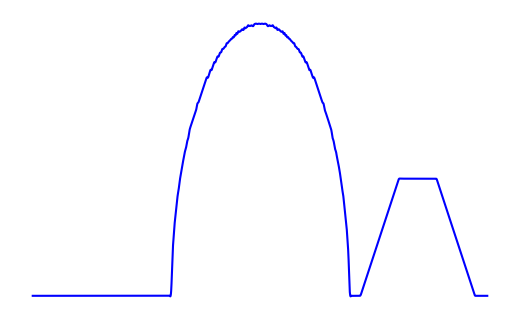

In [9]:
# the 1d profile of the sinogram

# Assuming sinogram is 2D: (detector_pixels, angles)
sinogram_45 = sinogram[:, 45]  # Get 45° projection (1D)

# Original vector
x = np.arange(len(sinogram_45))
y = sinogram_45

# Interpolation function (cubic is smooth)
interp_func = interp1d(x, y, kind='cubic')

# New, denser x-axis
x_dense = np.linspace(0, len(y) - 1, 10 * len(y))  # 10× more points
y_dense = interp_func(x_dense)

# Plot it
plt.figure(figsize=(5, 3), facecolor='white')
plt.plot(x_dense, y_dense, color='blue', linewidth=1.5)
plt.axis('off')
plt.gca().set_position([0, 0, 1, 1])
plt.savefig(save_here + "45_line.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line.png", format='png', bbox_inches='tight', pad_inches=0)
plt.show()

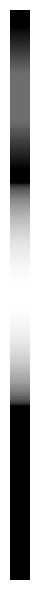

In [10]:
# same profile but on the sinogram plane itself

theta_index = 45
column = sinogram[:, theta_index]  # shape (N,)

# Repeat the column to make a visible image (e.g. 20 pixels wide)
projection_img = np.tile(column[:, np.newaxis], (1, 20))  # shape (N, 20)

plt.figure(figsize=(0.5, 6), facecolor='white')  # Aspect ratio = tall
plt.axis("off")
plt.imshow(
    projection_img,
    cmap='gray',
    aspect='auto',
    origin='lower',  # flip to 'upper' if needed
    extent=(44.5, 45.5, 0, len(column)),
    interpolation='none'  # IMPORTANT: preserve hard pixel edges
)
plt.tight_layout()
plt.savefig(save_here + "45_line_all_object.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line_all_object.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line_all_object.png", format='png', bbox_inches='tight', pad_inches=0)
plt.show()

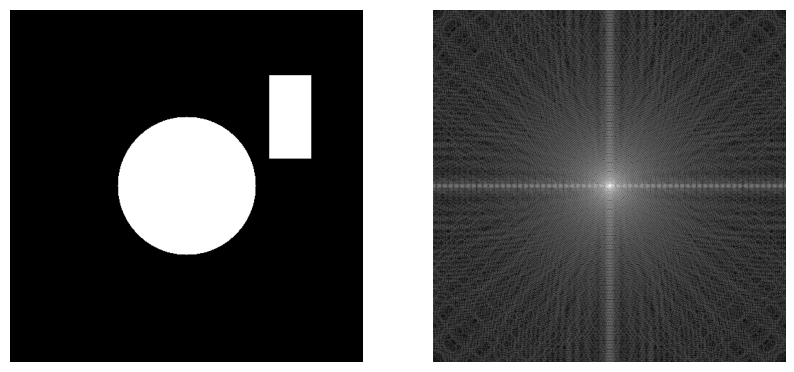

In [11]:
# the phantom and its fourier transform

phantom_fourier = np.fft.fft2(phantom_norm)
phantom_fourier = np.fft.fftshift(phantom_fourier)
phantom_fourier = 10 * np.log(1 + np.abs(phantom_fourier))

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(phantom_norm, cmap="gray")
plt.axis("off")

plt.subplot(122)
plt.imshow(phantom_fourier, cmap="gray")
plt.axis("off")

plt.show()

In [24]:
# a function that construct the fourier transform of the object using the sinogram slice by slice

%matplotlib notebook

def foruier_slice_theorem(sino, fourier_plane, complex_fft, all_angles, slice_angle):
    
    size = sino.shape[0]
    center = size // 2
    
    angle_index = np.where(all_angles == slice_angle)[0][0]
    slice_angle_rad = np.deg2rad(slice_angle)
    
    projection  = sino[:, angle_index]
    
    slice_fft = np.fft.fft(projection)
    slice_fft = np.fft.fftshift(slice_fft)
    
    magnitude = np.abs(slice_fft)
    magnitude = np.log1p(magnitude)  # log(1 + |F|) for better contrast
    magnitude /= magnitude.max()
    
    # Draw in both directions
    for i in range(size):
        offset = i - center  # goes from -center to +center
        
        # radial coordinate in frequency domain
        x = int(round(center - offset * np.cos(slice_angle_rad)))
        y = int(round(center + offset * np.sin(slice_angle_rad)))
    
        if 0 <= x < size and 0 <= y < size:
            fourier_plane[y, x] = magnitude[i]
            complex_fft[y, x] = slice_fft[i]


fourier_plane = np.zeros((sinogram.shape[0], sinogram.shape[0]), dtype=np.float32)
complex_plane = np.zeros_like(fourier_plane) # this is for the reconstruction we need the complex values too
snapshot_angles = [0, 45, 90, 135, 179]


plt.ion()
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(fourier_plane, cmap='gray', vmin=0, vmax=1)
title = ax.set_title("")
ax.axis('off')

# Loop through angles
for i, ang in enumerate(azi_angles):
    foruier_slice_theorem(sinogram, fourier_plane, complex_plane, azi_angles, ang)
    
    img.set_data(fourier_plane)         # update image
    fig.canvas.draw()
    fig.canvas.flush_events()
    # time.sleep(1.5)
    
    if ang in snapshot_angles:
        fig.savefig(save_here + f"fourier_slice_{int(ang)}deg.pdf", format='pdf',  dpi=300, bbox_inches='tight', pad_inches=0)

plt.ioff()
plt.show()

<IPython.core.display.Javascript object>

C:\Users\tomerf\AppData\Local\Temp\ipykernel_15600\976136667.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  complex_fft[y, x] = slice_fft[i]


In [25]:
# to stop the interactive mode

%matplotlib inline

plt.ioff()              # Turn off interactive mode
plt.close('all')        # Close all figures
plt.rcdefaults()        # Reset rcParams to default
plt.style.use('default')  # Clear any Jupyter or dark style overrides

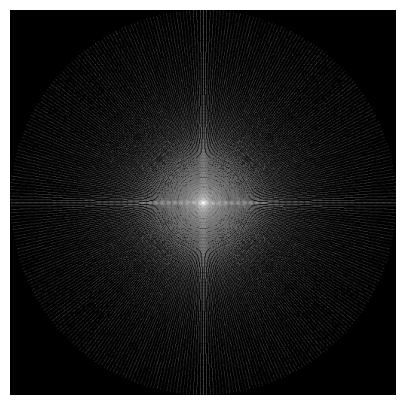

In [26]:
# the final result of the reconstruction

plt.figure(figsize=(10,5))

plt.imshow(fourier_plane, cmap='gray', vmin=0, vmax=1)
plt.axis("off")
plt.savefig(save_here + "complete_fourier_slice_theorem.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "complete_fourier_slice_theorem.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()


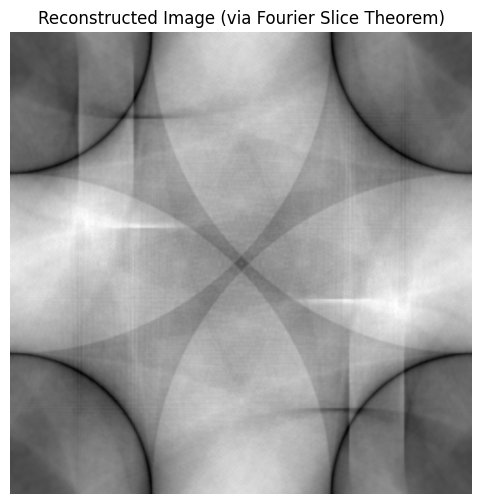

In [27]:
# reconstruction of the phantom from the polar grid

# Apply inverse FFT
ifft_input = np.fft.ifftshift(complex_plane)
reconstructed = np.fft.ifft2(ifft_input)
reconstructed = np.real(reconstructed)

# Normalize
reconstructed -= reconstructed.min()
reconstructed /= reconstructed.max()

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap='gray')
plt.axis('off')
plt.title("Reconstructed Image (via Fourier Slice Theorem)")
plt.show()


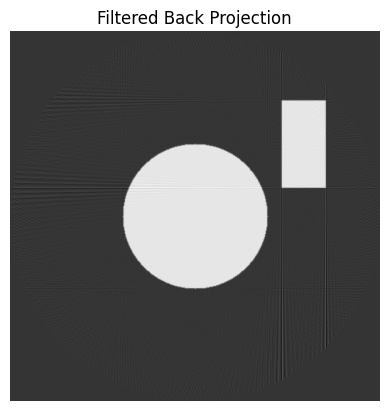

In [39]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=azi_angles, filter_name='ramp', circle=True)

plt.imshow(reconstruction_fbp, cmap='gray')
plt.title("Filtered Back Projection")
plt.axis('off')
plt.show()